In [7]:
import datetime
import math
import os
from os import path, replace
from pathlib import Path
import sys
from pprint import pprint

import random

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

In [8]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.abspath(".")))

from util.helpers import reseed
from dataset import EndoVisDataset, inv_im_trans, im_mean

In [12]:
MAIN_FOLDER = Path.home() / "plaksha/SurgicalAI/data/endovis/endo17/data"
TRAIN_VIDEOS_PATH = MAIN_FOLDER / "frames/train"
TRAIN_MASKS_PATH = MAIN_FOLDER / "masks/train/type_masks"
SAVE_DIR = Path("./artifacts/saved_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Set seed to ensure the same initialization
reseed(42)

transforms_dict = {}
# These set of transform is the same for im/gt pairs, but different among the 3 sampled frames
transforms_dict["single_image"] = transforms.Compose([
    transforms.ColorJitter(0.01, 0.01, 0.01, 0),
])

transforms_dict["pair_image_gt"] = [
    transforms.Compose([
        transforms.RandomAffine(15, shear=10, interpolation=InterpolationMode.BILINEAR, fill=im_mean) # for images
    ]),
    transforms.Compose([
        transforms.RandomAffine(15, shear=10, interpolation=InterpolationMode.NEAREST, fill=0) # for masks
    ])
]

# These transform are the same for all pairs in the sampled sequence
transforms_dict["seq_image"] = transforms.Compose([
    transforms.ColorJitter(0.1, 0.03, 0.03, 0),
    transforms.RandomGrayscale(0.05),
])


transforms_dict["seq_image_gt"] = [
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((384, 384), scale=(0.36,1.00), interpolation=InterpolationMode.BILINEAR) # for images
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((384, 384), scale=(0.36,1.00), interpolation=InterpolationMode.NEAREST) # for masks
    ])
]

train_dataset = EndoVisDataset(
    TRAIN_VIDEOS_PATH,
    TRAIN_MASKS_PATH,
    num_iterations=100,#config["iterations"],
    batch_size=2,#config["batch_size"],
    max_jump=2,
    num_frames=8,
    max_num_obj=3,
    transform=transforms_dict,
    subset=[6]
)

1 out of 8 videos accepted in /Users/syedal/plaksha/SurgicalAI/data/endovis/endo17/data/frames/train.


In [13]:
def plotDatasetSample(dataset, rows):
    random_idx = random.randint(0, len(dataset))
    print(f"Random index: {random_idx}")
    video_seq = dataset[random_idx]
    print('rgb', video_seq['rgb'].shape)
    print('first_frame_gt', video_seq['first_frame_gt'].shape)
    print('cls_gt', video_seq['cls_gt'].shape)
    print('selector', video_seq['selector'])
    print('info', video_seq['info'])

    batch_size = video_seq['rgb'].shape[0]

    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    jump = batch_size // rows
    
    for i in range(rows):
        # Plot RGB image
        current_idx = i*jump
        print("Frame Index", video_seq['info']['frames'][current_idx])
        rgb_image = inv_im_trans(video_seq['rgb'][current_idx]).permute(1,2,0).numpy()
        axes[i, 0].imshow(rgb_image)
        axes[i, 0].axis('off')
        
        # Plot binary mask
        mask = video_seq['cls_gt'][current_idx][0]
        og_mask = video_seq['og_masks'][current_idx]
        print(f"Unique classes in mask {i}", np.unique(mask))
        print(f"Unique classes in og_mask {i}", np.unique(og_mask))

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()    

Random index: 163
rgb torch.Size([8, 3, 384, 384])
first_frame_gt (1, 3, 384, 384)
cls_gt (8, 1, 384, 384)
selector tensor([1., 1., 0.])
info {'name': 'instrument_dataset_06', 'frames': ['146', '147', '148', '149', '150', '151', '152', '153'], 'num_objects': 2}
Frame Index 146
Unique classes in mask 0 [0 1 2]
Unique classes in og_mask 0 [0 2 3]
Frame Index 148
Unique classes in mask 1 [0 1 2]
Unique classes in og_mask 1 [0 2 3]
Frame Index 150
Unique classes in mask 2 [0 1 2]
Unique classes in og_mask 2 [0 2 3]
Frame Index 152
Unique classes in mask 3 [0 1 2]
Unique classes in og_mask 3 [0 2 3]


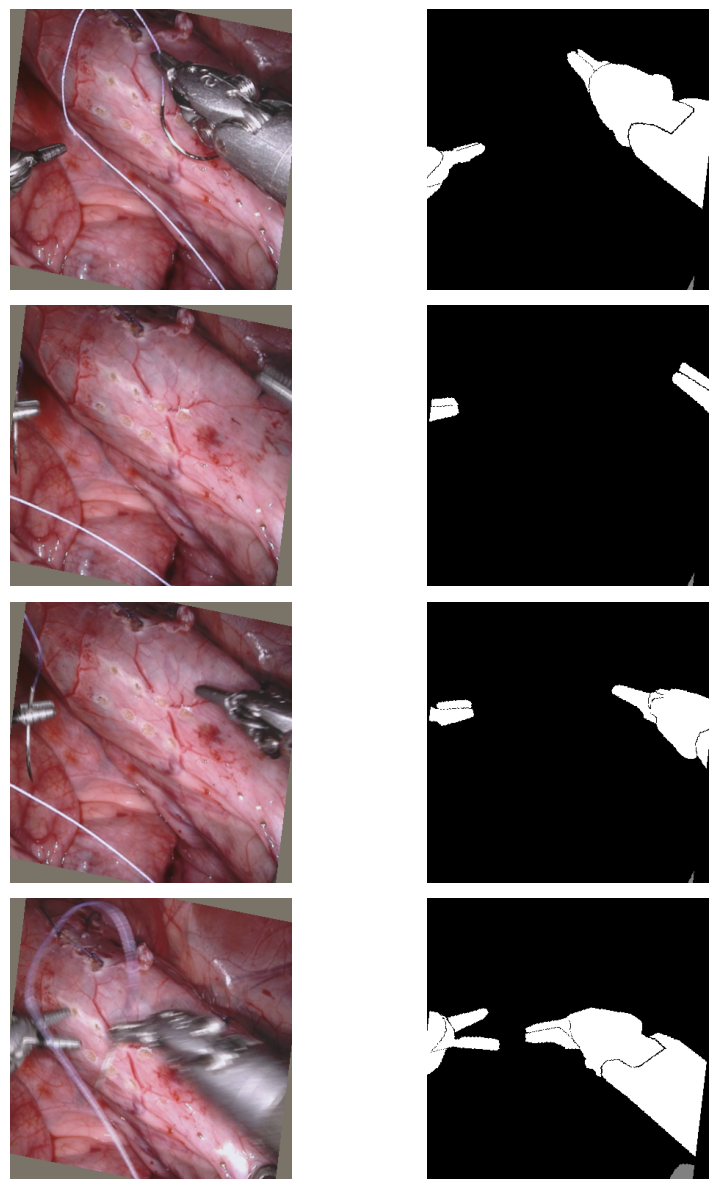

In [14]:
plotDatasetSample(train_dataset, 4)

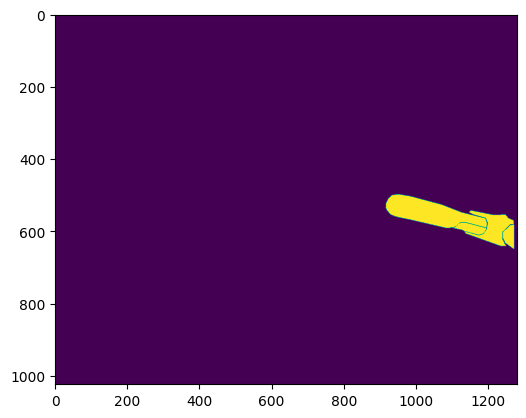

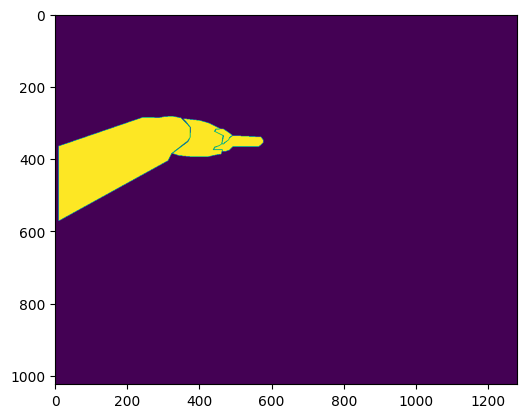

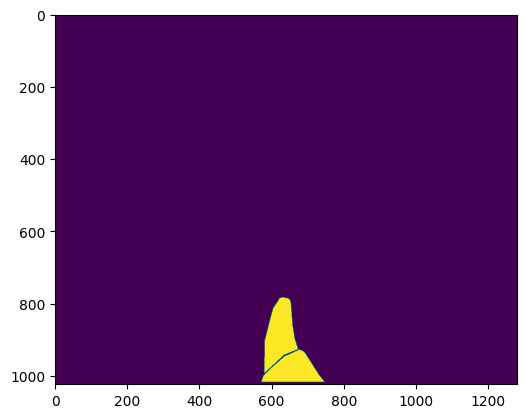

In [12]:
data = train_dataset[163]
for i in data['first_frame_gt'][0]:
    plt.imshow(i)
    plt.show()

In [18]:
first_frame = data['first_frame_gt']
print("First Frame Shape", first_frame.shape)
mask = data['cls_gt']
print("Mask Shape", mask.shape)
og_mask = data['og_masks']
print("OG Mask Shape", og_mask.shape)

First Frame Shape (1, 6, 384, 384)
Mask Shape (8, 1, 384, 384)
OG Mask Shape (8, 384, 384)


# Inference Data

In [20]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch

from inference.data.mask_mapper import MaskMapper
from inference.data.video_reader import VideoReader

mapper = MaskMapper()

In [7]:
data_path = Path('/Users/syedal/plaksha/SurgicalAI/data/endovis/endo17/data')

frames_path = data_path / 'frames/test/instrument_dataset_09'
masks_path = data_path / 'masks/test/type_masks/instrument_dataset_09'
vid_reader = VideoReader(frames_path, frames_path, masks_path, size=-1, use_all_mask=True)

In [25]:
for data in tqdm(vid_reader):
    frame = data['rgb']
    original_mask = data['mask']
    info = data['info']
    frame_name = info['frame']
    shape = info['shape'] # original size
    need_resize = info['need_resize']
    idx = info['idx']

    # Map possibly non-continuous labels to continuous ones
    mask, labels = mapper.convert_mask(original_mask, exhaustive=False)
    

  0%|          | 0/300 [00:00<?, ?it/s]


AssertionError: Old labels found in non-exhaustive mode

In [24]:
mapper.labels

[1, 2, 6]

In [23]:
mapper.remappings

{1: 1, 2: 2, 6: 3}

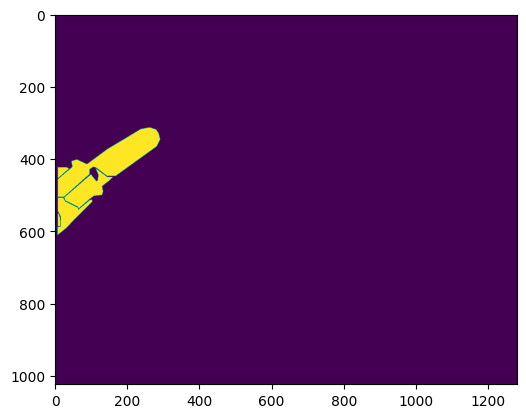

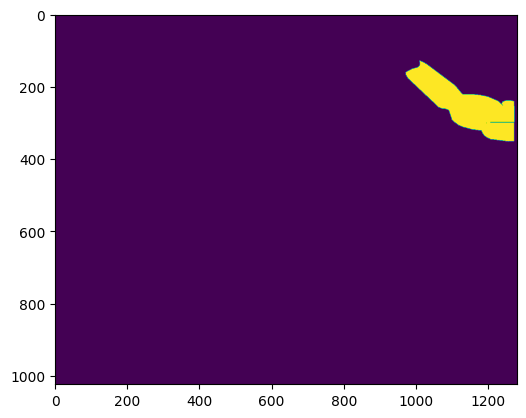

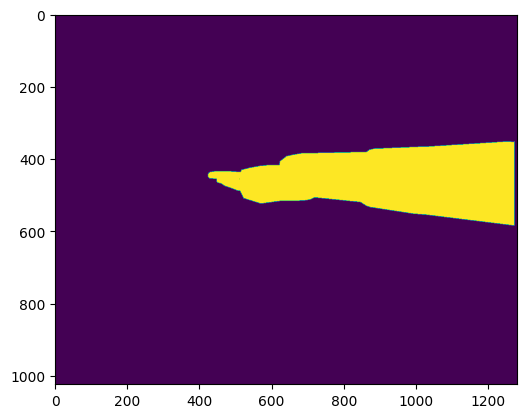

In [14]:
for i in mask:
    plt.imshow(i)
    plt.show()